In [297]:
import os
import xml.etree.ElementTree as ET
import warnings
from PIL import Image, ImageOps
import pandas as pd 
import numpy as np



In [298]:
def getdata(path):
    # Create paths
    images_path = [] 
    annotations_path = []
    #Divice path follow type
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            file_path = os.path.join(dirname, filename)
            if file_path[-3:] == 'xml':
                annotations_path.append(file_path)
            else:
                images_path.append(file_path)
    #check if loaded all data
    if len(images_path) == 853:
        print("Ok Load done")
    else:
        print("Not Ok...")
    return annotations_path,images_path

def dfmode(annotations_path):
    #create dataframe to save data
    df=pd.DataFrame(columns=['xmin','xmax','ymin','ymax','file_name','label'])
  
    for xml_file in annotations_path:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        file_name = root.find('filename').text
          
    # foreach object
        for obj in root.findall('object'):
            r = {
                'xmin': int(obj.find('bndbox').find('xmin').text),
                'ymin': int(obj.find('bndbox').find('ymin').text),
                'xmax': int(obj.find('bndbox').find('xmax').text),
                'ymax': int(obj.find('bndbox').find('ymax').text),
                'file_name': file_name,
                'label': obj.find('name').text,
            }
            # Encode label
            # 0 = without_mask
            # 1 = with_mask
            # 2 =  mask_weared_incorrect

            if (r['label']=='without_mask'):
                    r['label']=0
            elif (r['label']=='with_mask'):
                    r['label']=1
            else:
                    r['label']=2
            df = df.append(r, ignore_index=True)
    return df

Get data from path, return annotations path and images path. Get information from annototions and save to dataframe

In [299]:
annotations_path,images_path=getdata('E:/UwayInternshipLearning/FaceMaskDetection/Face-Mask-Detection/input')
df=dfmode(annotations_path)


Ok Load done


C:\Users\Admin\AppData\Local\Temp\ipykernel_2676\3608491269.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(r, ignore_index=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_2676\3608491269.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(r, ignore_index=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_2676\3608491269.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(r, ignore_index=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_2676\3608491269.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(r, ignore_index=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_

In [300]:
df.head()

,xmin,xmax,ymin,ymax,file_name,label
0,79,109,105,142,maksssksksss0.png,0
1,185,226,100,144,maksssksksss0.png,1
2,325,360,90,141,maksssksksss0.png,0
3,321,354,34,69,maksssksksss1.png,1
4,224,261,38,73,maksssksksss1.png,1


Devide data to train, test, valid set

In [301]:
def train_test_valid_split(df):
    Ytest=df.sample(frac=0.1, replace=False)
    Xtest=pd.DataFrame(columns=['file_name'])   
    Xtest=Ytest.pop('file_name')

    Yvali=df.sample(frac=0.1,replace=False)
    Xvali=pd.DataFrame(columns=['file_name'])
    Xvali=Yvali.pop('file_name')

    Ytrain=df.sample(frac=0.8,replace=False)
    Xtrain=pd.DataFrame(columns=['file_name'])
    Xtrain=Ytrain.pop('file_name')

    return  Xtrain,Ytrain,Xtest,Ytest,Xvali,Yvali
    
    
train_X, train_Y, test_X, test_Y, val_X, val_Y=train_test_valid_split(df)

In [302]:
print('train_X.shape =', train_X.shape)
print('train_Y.shape =', train_Y.shape)
print('val_X.shape   =', val_X.shape)
print('val_Y.shape   =', val_Y.shape)
print('test_X.shape  =', test_X.shape)
print('test_Y.shape  =', test_Y.shape)

train_X.shape = (3258,)
train_Y.shape = (3258, 5)
val_X.shape   = (407,)
val_Y.shape   = (407, 5)
test_X.shape  = (407,)
test_Y.shape  = (407, 5)


In [303]:
train_Y.head()

,xmin,xmax,ymin,ymax,label
3144,282,296,75,90,0
3361,285,311,71,104,1
2835,157,244,108,208,1
107,80,153,58,141,1
227,358,388,116,141,1


Path in images_path include path for 853 image. We need the path to images corresponding with each face, each sample in test,training,valid set 

In [304]:
path='E:/UwayInternshipLearning/FaceMaskDetection/Face-Mask-Detection/input'

path_to_train_X=[]
path_to_val_X=[]
path_to_test_X=[]

for dirname, _,_ in os.walk(path):
    if dirname[-6:]=='images':
        for i in train_X:
            file_path=os.path.join(dirname,i)  
            path_to_train_X.append(file_path)  
        for i in val_X:
            file_path=os.path.join(dirname,i)
            path_to_val_X.append(file_path)
        for i in test_X:
            file_path=os.path.join(dirname,i)
            path_to_test_X.append(file_path)
            


In [305]:
df['label'].value_counts()


1    3232
0     717
2     123
Name: label, dtype: int64

Crop faces from image for training

In [306]:
from PIL import Image,ImageOps
import numpy as np
import matplotlib.pyplot as plt


In [307]:
def crop(frame_pos,path_image:list,new_size):
    xmin=[]
    xmax=[]
    ymin=[]
    ymax=[]

    for i in frame_pos['xmin']:
        xmin.append(i)
    for i in frame_pos['xmax']:
        xmax.append(i)
    for i in frame_pos['ymin']:
        ymin.append(i)
    for i in frame_pos['ymax']:
        ymax.append(i)

    h,w=new_size

    arr_img=np.zeros((len(path_image),h*w))

    for i in range(len(path_image)):
        im=Image.open(path_image[i])
        im=im.convert('RGB')
        im_arr=np.array(im)
        im_arr=im_arr[ymin[i]:ymax[i],xmin[i]:xmax[i],:]
        image=Image.fromarray(im_arr)
        image=image.resize(new_size)
        image=ImageOps.grayscale(image)
        image=np.array(image)
        flat_arr = np.reshape(image,image.shape[0]*image.shape[1])

        arr_img[i,:]=flat_arr
    
    return arr_img
    

In [308]:
new_size=(50,50)
train_X_set=crop(train_Y,path_to_train_X,new_size)
val_X_set=crop(val_Y,path_to_val_X,new_size)
test_X_set=crop(test_Y,path_to_test_X,new_size)

In [319]:
test_X_set.shape

(407, 2500)

In [310]:
print('train_X.shape =', len(train_X_set))
print('train_Y.shape =', train_Y.shape)
print('val_X.shape   =', len(val_X_set))
print('val_Y.shape   =', val_Y.shape)
print('test_X.shape  =', len(test_X_set))
print('test_Y.shape  =', test_Y.shape)

train_X.shape = 3258
train_Y.shape = (3258, 5)
val_X.shape   = 407
val_Y.shape   = (407, 5)
test_X.shape  = 407
test_Y.shape  = (407, 5)


Drop box information out of Y dataset

In [311]:
def del_box_infor(dtaframe):
    del dtaframe['xmin']
    del dtaframe['xmax']
    del dtaframe['ymin']
    del dtaframe['ymax']

del_box_infor(train_Y)
del_box_infor(val_Y)
del_box_infor(test_Y)

In [312]:
print('train_X.shape =', len(train_X_set))
print('train_Y.shape =', train_Y.shape)
print('val_X.shape   =', len(val_X_set))
print('val_Y.shape   =', val_Y.shape)
print('test_X.shape  =', len(test_X_set))
print('test_Y.shape  =', test_Y.shape)

train_X.shape = 3258
train_Y.shape = (3258, 1)
val_X.shape   = 407
val_Y.shape   = (407, 1)
test_X.shape  = 407
test_Y.shape  = (407, 1)


In [313]:
train_X_set[0]
# make a 1-dimensional view of arr
im=Image.open(path_to_test_X[0])
im=ImageOps.grayscale(im)
im_arr=np.array(im)
flat_arr = np.reshape(im_arr,im_arr.shape[0]*im_arr.shape[1])
flat_arr

array([44, 44, 50, ..., 24, 20, 14], dtype=uint8)

Let see the result

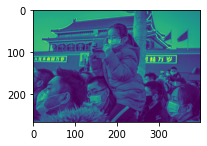

In [314]:
im=Image.open(path_to_train_X[30])
im=ImageOps.grayscale(im)
plt.figure(figsize=(3,3))
plt.imshow(im)
plt.show()



In [329]:
print('train_X_set.shape =', train_X_set.shape)
print('train_Y.shape =', train_Y.shape)
print('val_X_set.shape   =', val_X_set.shape)
print('val_Y.shape   =', val_Y.shape)
print('test_X_set.shape  =', test_X_set.shape)
print('test_Y.shape  =', test_Y.shape)

train_X_set.shape = (3258, 2500)
train_Y.shape = (3258, 1)
val_X_set.shape   = (407, 2500)
val_Y.shape   = (407, 1)
test_X_set.shape  = (407, 2500)
test_Y.shape  = (407, 1)


Build  Basic CNN Model

In [333]:
len(train_Y)

3258

In [316]:
def sigmoid(S):
    '''
    Computes sigmoid function for each element of array S.
    You can use this function in `compute_nnet_outputs` function.
    '''
    return 1 / (1 + np.exp(-S))

def compute_nnet_outputs(Ws, X, need_all_layer_outputs):
    '''
    Computes the outputs of Neural Net by forward propagating X through the net.
    
    Parameters
    ----------
    Ws : list of numpy arrays
        Ws[l-1] is W of layer l with l >= 1 (layer 0 is input layer, 
        it doesn't have W); W of layer l will have the shape of 
        (d^(l-1)+1, d^(l)), where  d^(l-1) is the number of neurons 
        (not count the +1 neuron) of layer l-1 and  d^(l) is the number of 
        neurons (not count the +1 neuron) of layer l.
    X : numpy array, shape (N, d+1)
        The matrix of input vectors (each row corresponds to an input vector); 
        the first column of this matrix is all ones (corresponding to x_0).
    need_all_layer_outputs : bool
        If this var is true, we'll return a list of layer's-outputs (we'll 
        need this list when training); otherwise, we'll return the final 
        layer's output.
    Returns
    -------
    If `need_all_layer_outputs` is false, return
        A : numpy array, shape (N, K=10)
            The maxtrix of output vectors of final layer; each row is an 
            output vector (containing each class's probability given the 
            corresponding input vector).
    Else, return
        As : list of numpy arrays
            As[l] is the matrix of output vectors of layer l (l=0 will 
            correspond to input layer); each row is an output vector 
            (corresponding to an input vector); if layer l is not the final 
            layer, the first column of this matrix is all ones.
    '''    
    # TODO

    As=[X]
    A=X

    for i in Ws:
        A=sigmoid(A.dot(i))
        A=np.append(np.array([[1]]*len(A)),A,axis=1)
        As.append(A)
    As[len(As)-1]=np.delete(As[len(As)-1],0,1)

    if (need_all_layer_outputs):
        return As
    else:
        return As[len(As)-1]
        


In [336]:
def train_nnet(X, Y, val_X, val_Y, 
               hid_layer_sizes, 
               mb_size, learning_rate, max_epoch):
    '''
    Trains Neural Net on the dataset (X, Y); also prints out mean binary error 
    (the percentage of misclassified data points) on training set and 
    validation set during training
    Cost function: mean cross-entropy error
    Optimization algorithm: SGD
    
    Parameters
    ----------
    X : numpy array, shape (N, d + 1)
        The matrix of input vectors (each row corresponds to an input vector); 
        the first column of this matrix is all ones (corresponding to x_0).
    Y : numpy array, shape (N,) 
        The vector of outputs.
    val_X, val_Y : validation data, similar to X and Y
    hid_layer_sizes : list
        The list of hidden layer sizes; e.g., hid_layer_sizes = [20, 10] means
        the Net has 2 hidden layers, the 1st one has 20 neurons, and the 2nd 
        one has 10 neurons (not count the +1 neurons).
    mb_size : int
        Minibatch size of SGD.
    learning_rate : float
        Learning rate of SGD.
    max_epoch : int
        After this number of epochs, we'll terminate SGD.

    Returns
    -------
    (Ws, costs, errs) : tuple
        Ws : list of numpy arrays
            Ws[l-1] is W of layer l with l >= 1 (layer 0 is input layer, 
            it doesn't have W); W of layer l will have the shape of 
            (d^(l-1)+1, d^(l)), where d^(l-1) is the number of neurons 
            (not count the +1 neuron) of layer l-1 and d^(l) is the number of 
            neurons (not count the +1 neuron) of layer l.
        costs : list, len = max_epoch
            The list of costs after each epoch.
        errs : list, len = max_epoch
            The list of mean binary errors (on the training set) after each epoch.
    '''
    # Prepare for training
    K = len(np.unique(Y)) # Num classes
    layer_sizes = [X.shape[1] - 1] + hid_layer_sizes + [K]
    np.random.seed(0) # This will fix the randomization; 
                      # so, you and me will have the same results
    Ws = [np.random.randn(layer_sizes[i] + 1, layer_sizes[i + 1]) 
          / np.sqrt(layer_sizes[i] + 1) 
          for i in range(len(layer_sizes) - 1)] # Secret formula to init Ws ;-)
    one_hot_Y = np.zeros((len(Y), K))
    # one_hot_Y[np.arange(len(Y)), Y] = 1
    for i in range(len(Y)):
        if(Y[i]==0):
            one_hot_Y[i][0]=1
        elif(Y[i]==1):
            one_hot_Y[i][1]=1
        else:
            one_hot_Y[i][2]=1
            
    errs = [] # To save mean binary errors on training set during training
    val_errs = [] # To save mean binary errors on validation set during training
    N = len(X) # Num training pairs
    rnd_idxs = np.arange(N) # Random indexes    

    # Train
    for epoch in range(max_epoch):
        np.random.shuffle(rnd_idxs)
        for start_idx in range(0, N, mb_size):
            # Get minibach
            mb_X = X[rnd_idxs[start_idx:start_idx+mb_size]]
            mb_Y = one_hot_Y[rnd_idxs[start_idx:start_idx+mb_size]]
            # Forward-prop
            As = compute_nnet_outputs(Ws, mb_X, True)
            # Back-prop; on the way, compute each layer's gradient and update its W
            # TODO: delta = ... (task 1)
            delta= As[len(As)-1] - mb_Y
            # TODO: grad = ... (task 2)
            if start_idx == N - N % mb_size:
                grad=As[len(As)-2].T.dot(delta) /(N % mb_size)
            else:
                grad=As[len(As)-2].T.dot(delta) /mb_size
            # Notes on task 2: 
            # if N % mb_size != 0 
            # => last minibatch's size < mb_size
            # => when computing grad for last minibatch, 
            #    we need to divide by last minibatch's size instead of mb_size
            
            Ws[-1] -= learning_rate * grad

            for i in range(2, len(Ws) + 1):
                # Compute delta's of layer l from delta's of layer l+1 (on a mini-batch)
                delta = delta.dot(Ws[-i + 1].T[:, 1:]) * As[-i][:, 1:] * (1 - As[-i][:, 1:])
                # TODO: Compute gradient of layer l from delta of layer l and outputs of layer l-1 (on a mini-batch)
                batch=mb_size

                if start_idx == N - N % mb_size:
                    if (N % mb_size !=0 ):
                        batch = N % mb_size
                        
                grad=As[len(As)-i-1].T.dot(delta) /batch
                
                # Notes on task 4: similar to notes on task 2         
                Ws[-i] -= learning_rate * grad

        # Compute training info, save it, and print it
        A = compute_nnet_outputs(Ws, X, False)

        err = np.mean(np.argmax(A, axis=1) != Y) * 100
        errs.append(err)
        
        val_A = compute_nnet_outputs(Ws, val_X, False)
        val_err = np.mean(np.argmax(val_A, axis=1) != val_Y) * 100
        val_errs.append(val_err)

        print('Epoch %d, train err %.3f%%, val err %.3f%%' %(epoch, err, val_err))
            
    return Ws, errs, val_errs


In [343]:
train_Y=np.array(train_Y)
val_Y=np.array(val_Y)
test_Y=np.array(test_Y)


In [346]:

Ws, train_errs, val_errs = train_nnet(train_X_set, train_Y, val_X_set, val_Y,
                                      hid_layer_sizes=[20], 
                                      mb_size=32, learning_rate=0.1, max_epoch=50)


C:\Users\Admin\AppData\Local\Temp\ipykernel_2676\2700355851.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-S))


Epoch 0, train err 20.196%, val err 23.587%
Epoch 1, train err 20.196%, val err 23.587%
Epoch 2, train err 20.196%, val err 23.587%
Epoch 3, train err 20.196%, val err 23.587%
Epoch 4, train err 20.196%, val err 23.587%
Epoch 5, train err 20.196%, val err 23.587%
Epoch 6, train err 20.196%, val err 23.587%
Epoch 7, train err 20.196%, val err 23.587%
Epoch 8, train err 20.196%, val err 23.587%
Epoch 9, train err 20.196%, val err 23.587%
Epoch 10, train err 20.196%, val err 23.587%
Epoch 11, train err 20.196%, val err 23.587%
Epoch 12, train err 20.196%, val err 23.587%
Epoch 13, train err 20.196%, val err 23.587%
Epoch 14, train err 20.196%, val err 23.587%
Epoch 15, train err 20.196%, val err 23.587%
Epoch 16, train err 20.196%, val err 23.587%
Epoch 17, train err 20.196%, val err 23.587%
Epoch 18, train err 20.196%, val err 23.587%
Epoch 19, train err 20.196%, val err 23.587%
Epoch 20, train err 20.196%, val err 23.587%
Epoch 21, train err 20.196%, val err 23.587%
Epoch 22, train err 

In [ ]:
import numpy as np
from activations import *
from cnn import*
from flatten import*
from fully_conected import*
from handle_data import *
from loss import *
from normalize import *
from Pooling import*

In [ ]:
from random import random

train_X_set[0]
batch_im=np.zeros((1,50,50,3))
im_arr=np.array(train_X_set[0])
start_batch=0
end_batch=1
batch_im[start_batch:end_batch,:,:,:]=im_arr

w1=np.random.randint(0,255,size=(3,3,1,16))
b=np.ones((1,1,1,16))

c1=convolution(batch_im,w1,0,1,b)
Z_conv1,catch_conv1=c1.forward()

p1=Pooling(1,(2,2))
Z_maxpool1,cache_maxpool1=p1.max_pool2d_forward(Z_conv1)
Z_maxpool1.shape

flat1,cache_size_flat1=Flatt_forward(Z_maxpool1)
flat1.shape

fully_con=fully_connected(flat1,2)
out=fully_con.forward()

batch=1
print(out)


# sig_forw=np.zeros((batch,2))
# for i in range(batch):
#     sig=Sigmoi(out[i,:])
#     sig_forw[i,:]=sig.sigmoi_forward()
# sig_forw

[[4.34706490e+09 4.34712701e+09]]


In [ ]:
def train_cnn(epochs,batch,train_X,train_Y,val_X,val_Y):
    K=len(np.unique(train_Y))
    one_hot_Y = np.zeros((len(train_Y),K))
    for i in range(len(train_Y)):
        if(train_Y[i]==0):
            one_hot_Y[i][0]=1
        elif(train_Y[i]==1):
            one_hot_Y[i][1]=1
        else:
            one_hot_Y[i][2]=1
    
    errs = [] # To save mean binary errors on training set during training
    val_errs = [] # To save mean binary errors on validation set during training
    N = len(train_X) # Num training pairs
    
    W1=np.random.randn(3,3,0,16)
    W2=np.random.randn(3,3,16,32)
    b=np.ones((1,1,1,5))

    for epoch in range(epochs):
        for strart_indx in range(0,N,batch):
            
            c1=convolution(train_X[i],W1,0,1,b)
            Zconv1,cache_conv1=c1.forward()
            
            p1=Pooling(1,2)
            Zpool1,cache_pool1=p1.max_pool2d_forward(Zconv1)
            
            # c2=convolution(Zpool1,W2,0,1,b)
            # Zconv2,cache_conv2=c2.forward()

            # p2=Pooling(1,2)
            # Zpool2,cache_pool2=p2.max_pool2d_forward(Zconv2)

            Z_flat,cache_flat_size=Flatt_forward(Zpool1)

            f=fully_connected(Z_flat,2)
            Zfull=f.forward()   
             
    

E:\UwayInternshipLearning\FaceMaskDetection\Face-Mask-Detection\input